In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [112]:
df_origin = pd.read_csv("merged_billboard_genre.csv")
df = df_origin.drop("duration_ms.1", axis=1)
df.to_csv("bb_combined.csv", index=None)
to_merge = df_origin[["title", "ranking", "genre"]]

In [113]:
df = pd.read_csv("bb_combined.csv")

In [114]:
df = pd.read_csv("bb_combined.csv")
df = df[["duration_ms", "explicit", 'danceability', 'energy',
         'loudness', 'mode', 'speechiness', 'acousticness',
         'liveness', 'valence', 'tempo']]

bool_cols = df.select_dtypes(include=['bool']).columns
int64_cols = df.select_dtypes(include=['int64']).columns

# For boolean columns, convert to float (True to 1.0 and False to 0.0)
# Since the request mentioned scipy and one-hot encoding, but converting bools directly to floats doesn't necessitate one-hot encoding, we'll proceed with direct conversion.
df[bool_cols] = df[bool_cols].astype(float)

# Convert int64 columns to float64
df[int64_cols] = df[int64_cols].astype(np.float64)
df

,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,250546.0,0.0,0.529,0.496,-9.007,1.0,0.0290,0.1730,0.2510,0.278,136.859
1,294986.0,0.0,0.609,0.923,-3.908,1.0,0.0338,0.1600,0.2950,0.961,115.996
2,261973.0,0.0,0.777,0.601,-5.931,1.0,0.1260,0.0406,0.0348,0.680,97.911
3,296693.0,0.0,0.725,0.487,-5.959,0.0,0.0368,0.2600,0.4310,0.599,136.086
4,257066.0,0.0,0.636,0.761,-6.389,0.0,0.0306,0.0517,0.0642,0.736,93.896
...,...,...,...,...,...,...,...,...,...,...,...
2395,214945.0,0.0,0.778,0.632,-5.600,0.0,0.0493,0.2740,0.0915,0.498,122.104
2396,246133.0,1.0,0.557,0.774,-5.275,0.0,0.3510,0.0120,0.3960,0.397,111.975
2397,185748.0,1.0,0.849,0.614,-7.323,1.0,0.3170,0.0282,0.0603,0.472,111.363
2398,244760.0,0.0,0.591,0.637,-6.365,0.0,0.0300,0.0107,0.1130,0.432,99.998


In [115]:
df.to_csv("bb.csv", index=False)

In [116]:
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

def min_max_norm(df, column):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[column].values.reshape(-1, 1))
    return scaled_data.flatten() 

def logistic_norm(df, column):
    # To handle zeros, we shift the data by the smallest non-zero value divided by 2
    # if there are zero values present
    min_nonzero = df[df[column] > 0][column].min() / 2 if (df[column] == 0).any() else 0
    transformed_data = 1 / (1 + np.exp(- (df[column] + min_nonzero)))
    
    return transformed_data

In [117]:
df["duration_ms"] = min_max_norm(df, "duration_ms")
df["loudness"] = min_max_norm(df, "loudness")
df["tempo"] = min_max_norm(df, "tempo")
df["speechiness"] = logistic_norm(df, "speechiness")
df["acousticness"] = logistic_norm(df, "acousticness")
df["liveness"] = logistic_norm(df, "liveness")
df.to_csv("bb_normalized.csv", index=False)

In [118]:
df.columns

Index(['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'liveness', 'valence', 'tempo'],
      dtype='object')

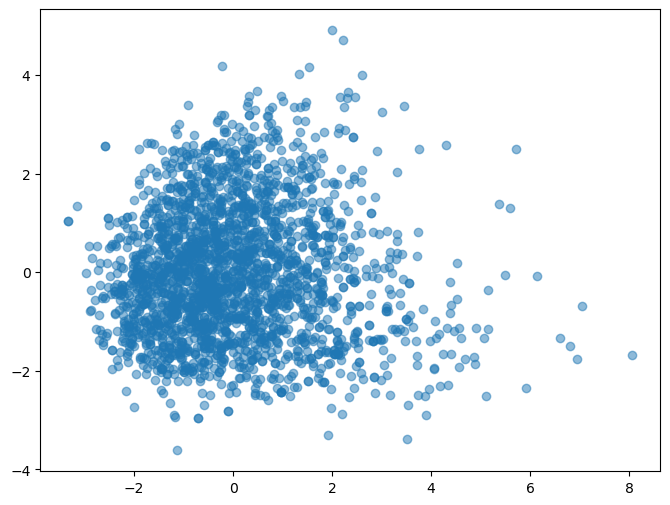

In [119]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca = PCA(n_components=2)  # We only want the first two principal components
principal_components = pca.fit_transform(scaled_data)

# Now, let's plot these two components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.show()

In [98]:
df["genre"].unique()

array(['Country', 'Rock', 'RnB', 'Pop', 'Hip-hop', 'EDM', 'Afro', 'Alt',
       'Latin', '?', 'Folk', 'Disney', 'Jazz'], dtype=object)

/var/folders/4k/z019px4j0t7csyx6sb1stb_m0000gn/T/ipykernel_17568/3774015395.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_colors)


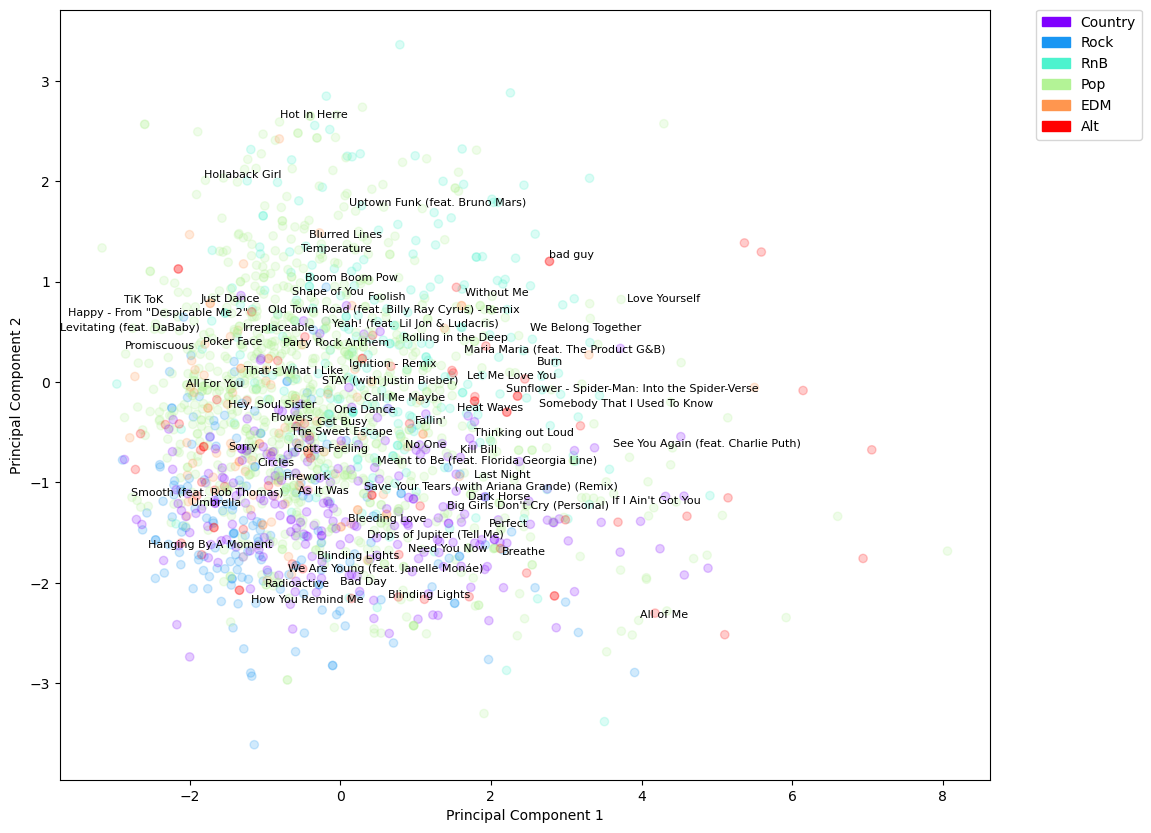

In [107]:
from adjustText import adjust_text
import matplotlib.patches as mpatches

# Create a column for the color codes
df_pca = pd.DataFrame(principal_components)
df_pca = df_pca.join(to_merge)
df_pca = df_pca[df_pca["genre"].isin(["Pop", "Hip-Hop", "RnB", "Country", "Rock", "EDM", "Alt"])]

color_labels = df_pca['genre'].unique()
num_colors = len(color_labels)
cmap = plt.cm.get_cmap('rainbow', num_colors)
genre_to_code = dict(zip(color_labels, range(num_colors)))
df_pca['color_code'] = df_pca['genre'].map(genre_to_code)

top_songs = df_pca.sort_values("ranking", ascending=True).head(70)

# Plotting all songs
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_pca[0], df_pca[1], alpha=0.2, c=df_pca['color_code'].map(lambda code: cmap(code)))

# Annotating the top 20 most popular songs
texts = []
for i, row in top_songs.iterrows():
    texts.append(plt.text(row[0], row[1], row['title'], fontsize=8))
    
adjust_text(texts)

# Labeling the axes and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
patches = [mpatches.Patch(color=cmap(genre_to_code[label]), label=label) for label in color_labels]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/Users/sidneyma/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


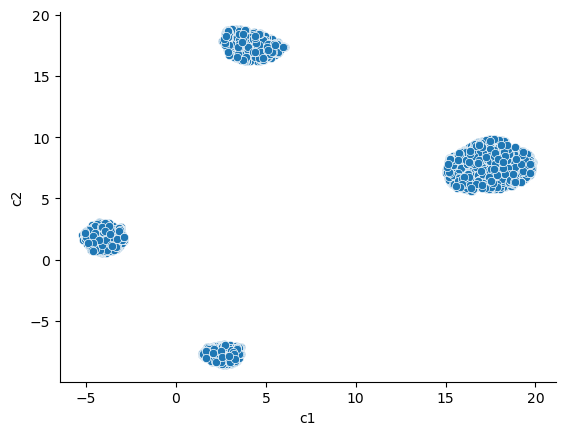

In [132]:
from umap import UMAP

umap_50_neigh = UMAP(n_components=2, random_state=1000, min_dist=0.1, n_neighbors=50)
ucs = umap_50_neigh.fit_transform(df)

ucs = pd.DataFrame(ucs,columns=['c1','c2'])
ucs.index = df.index

sns.scatterplot(data=ucs, x='c1', y='c2')
sns.despine()
ax = plt.gca()

/var/folders/4k/z019px4j0t7csyx6sb1stb_m0000gn/T/ipykernel_17568/1933681295.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_colors)


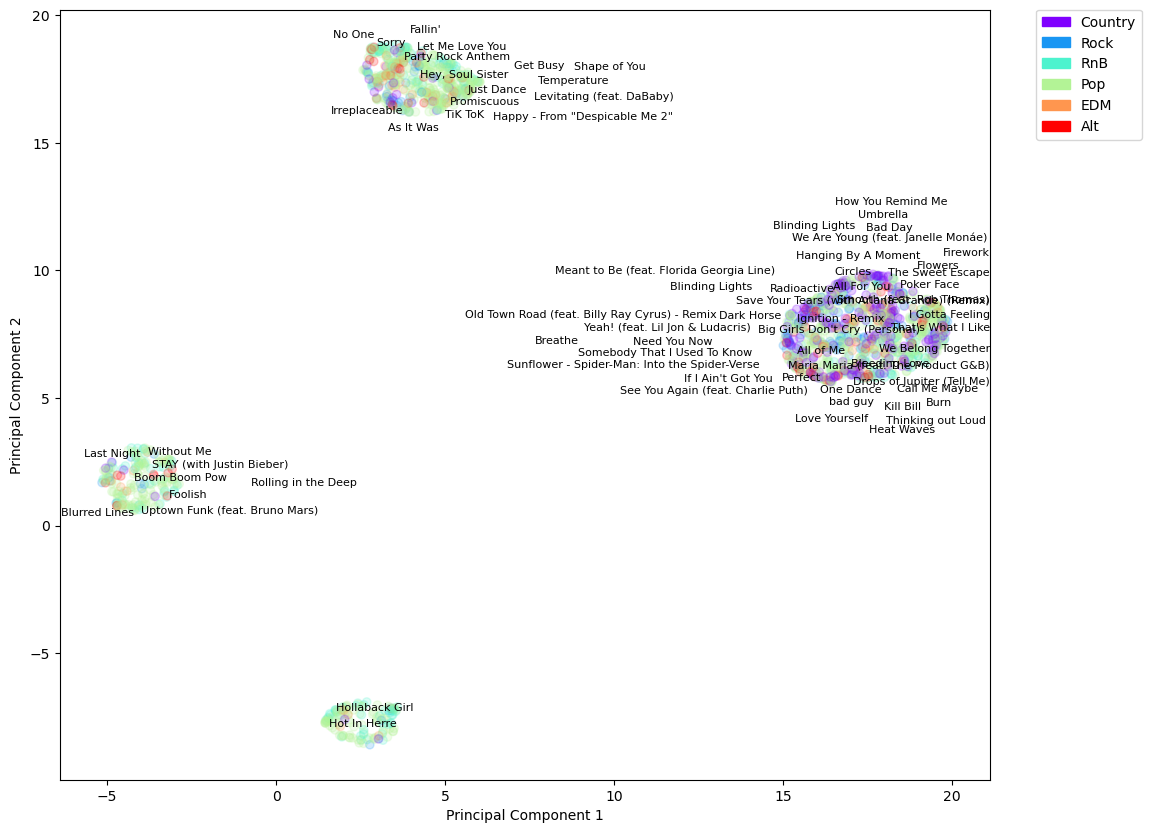

In [133]:
# Create a column for the color codes
df_ucs = pd.DataFrame(ucs)
df_ucs = df_ucs.join(to_merge)
df_ucs = df_ucs[df_ucs["genre"].isin(["Pop", "Hip-Hop", "RnB", "Country", "Rock", "EDM", "Alt"])]

color_labels = df_ucs['genre'].unique()
num_colors = len(color_labels)
cmap = plt.cm.get_cmap('rainbow', num_colors)
genre_to_code = dict(zip(color_labels, range(num_colors)))
df_ucs['color_code'] = df_ucs['genre'].map(genre_to_code)

top_songs = df_ucs.sort_values("ranking", ascending=True).head(70)

# Plotting all songs
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_ucs["c1"], df_ucs["c2"], alpha=0.2, c=df_ucs['color_code'].map(lambda code: cmap(code)))

# Annotating the top 20 most popular songs
texts = []
for i, row in top_songs.iterrows():
    texts.append(plt.text(row[0], row[1], row['title'], fontsize=8))
    
adjust_text(texts)

# Labeling the axes and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
patches = [mpatches.Patch(color=cmap(genre_to_code[label]), label=label) for label in color_labels]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

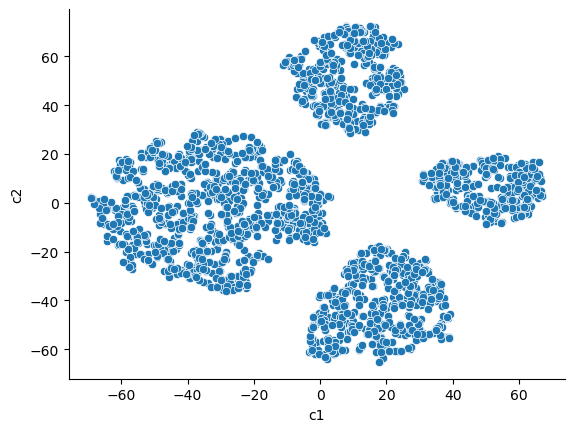

In [130]:
tsne_perp_20 = TSNE(perplexity = 20, random_state = 1000)
tcs= tsne_perp_20.fit_transform(df)
# construct the data frame
tcs= pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = df.index

sns.scatterplot(data=tcs, x ='c1', y='c2')
sns.despine()
ax = plt.gca()

/var/folders/4k/z019px4j0t7csyx6sb1stb_m0000gn/T/ipykernel_17568/4191489084.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_colors)


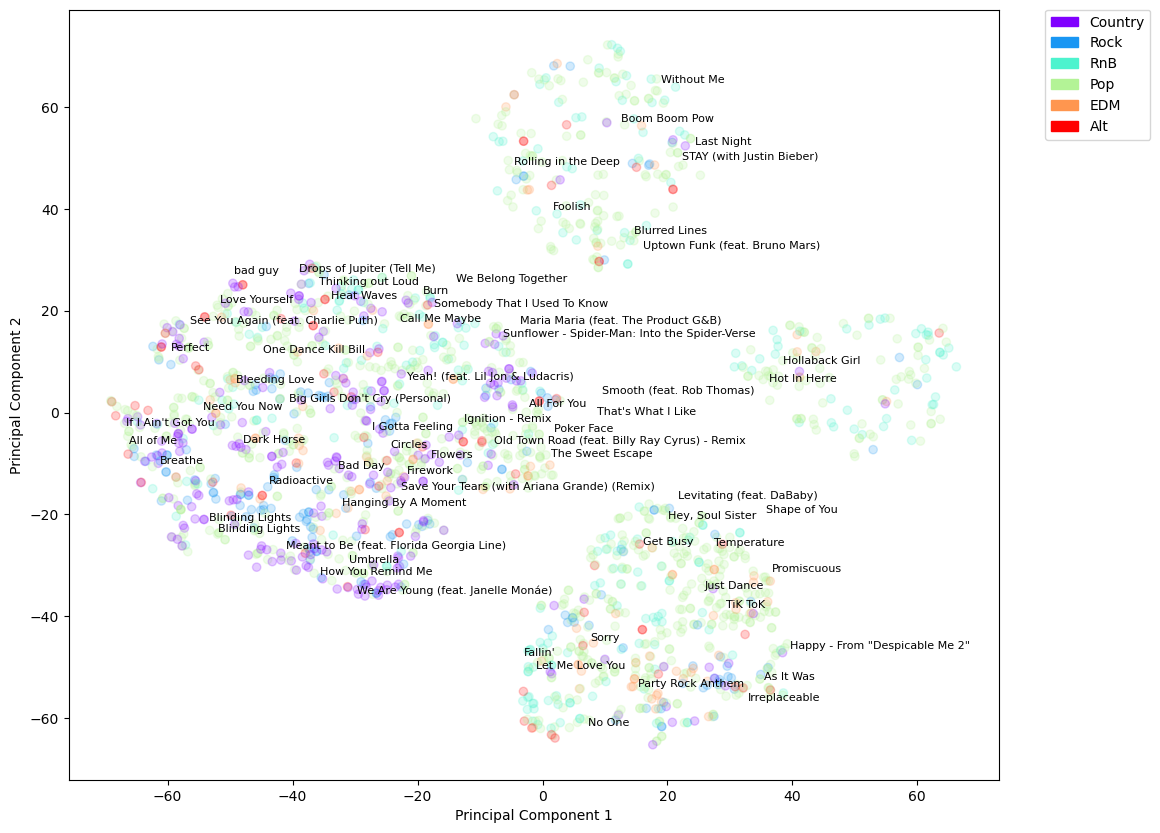

In [131]:
# Create a column for the color codes
df_tcs = pd.DataFrame(tcs)
df_tcs = df_tcs.join(to_merge)
df_tcs = df_tcs[df_tcs["genre"].isin(["Pop", "Hip-Hop", "RnB", "Country", "Rock", "EDM", "Alt"])]

color_labels = df_tcs['genre'].unique()
num_colors = len(color_labels)
cmap = plt.cm.get_cmap('rainbow', num_colors)
genre_to_code = dict(zip(color_labels, range(num_colors)))
df_tcs['color_code'] = df_tcs['genre'].map(genre_to_code)

top_songs = df_tcs.sort_values("ranking", ascending=True).head(70)

# Plotting all songs
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_tcs["c1"], df_tcs["c2"], alpha=0.2, c=df_tcs['color_code'].map(lambda code: cmap(code)))

# Annotating the top 20 most popular songs
texts = []
for i, row in top_songs.iterrows():
    texts.append(plt.text(row[0], row[1], row['title'], fontsize=8))
    
adjust_text(texts)

# Labeling the axes and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
patches = [mpatches.Patch(color=cmap(genre_to_code[label]), label=label) for label in color_labels]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)